## Create vegetation and land use type maps for each ecoregion

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import util
from tqdm import tqdm

In [3]:
#path to clean data folder
clean_data = "../data/clean/"
raw_data = "../data/raw/"

In [3]:

# Administrative boundaries
soco_bound = gpd.read_file(clean_data + "sonoma_county_boundary/sonoma_county_boundary.shp")
ca_state = gpd.read_file(clean_data + "ca_state_boundary/ca_state_boundary.shp")
zoning = gpd.read_file(raw_data + "soco_prmd_zoning/soco_prmd_zoning.shp") 

# Sonoma Veg
sonoma_veg_simp = gpd.read_file(clean_data + "sonoma_veg/sonoma_veg.shp")
sonoma_veg_percs = pd.read_csv(clean_data + "simple_veg_all.csv")

# CA EPA eco regions
ecoregions = gpd.read_file(clean_data + "soco_ecoregion_l4/soco_ecoregion_l4.shp")

# Land use 
landuse = gpd.read_file(raw_data + "soco_landuse/soco_landuse.shp") 
landuse_percs = pd.read_csv(clean_data + "landuse_all.csv")
protected_lands = gpd.read_file(clean_data + "soco_protected_lands/soco_protected_lands.shp")
urban_growth_boundaries = gpd.read_file(raw_data + "Vital_Lands_Data_Package/Base_Urban_Growth_Boundary.shp") 

# Critical Facilities
crit_facili = pd.read_csv(clean_data + "critical_facilities_stats.csv")

# demoggraphics
demographics = gpd.read_file(clean_data + "soco_demographics/soco_demographics.shp")

## Data Cleaning

In [5]:
ecoregions_simp = util.simplify_ecoregions(ecoregions)
soco_bound = soco_bound.to_crs(epsg=2226)
ca_state = ca_state.to_crs(epsg=2226)
landuse_simp = util.longname_landuse(landuse)

## MAPS

In [14]:
# Get the extent of sonoma county for mapping
xlim_soco = ([ecoregions_simp.total_bounds[0] - 0.009e6,  ecoregions_simp.total_bounds[2] +  0.009e6])
ylim_soco = ([ecoregions_simp.total_bounds[1] - 0.009e6,  ecoregions_simp.total_bounds[3] +  0.009e6])

<AxesSubplot:>

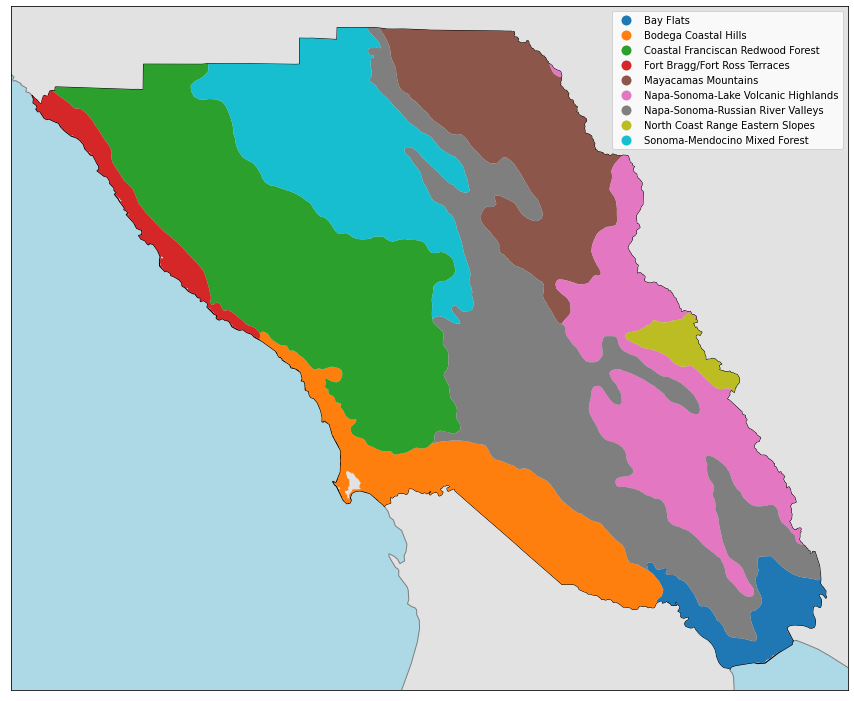

In [15]:
# map of all ecoregions

fig, ax = plt.subplots(figsize=(15,15))
ca_state.plot(ax=ax, edgecolor = "grey", color = "#e2e2e2")
soco_bound.plot(ax=ax, edgecolor = "black", color = "None")
ecoregions_simp.plot(ax=ax, column = "l4_simple", legend = True)
ax.set_xlim(xlim_soco)
ax.set_ylim(ylim_soco)
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('#add8e6')
ax

In [11]:
# Function to map the ecoregions
from typing import Union, Dict
def map_ecoregion_char(ecoregions: gpd.GeoDataFrame, characteristic: gpd.GeoDataFrame, which_eoi: str, cmap: Union[ListedColormap, Dict[str, str]], column: str):

    """Map each ecoregion characteristic

    Args:
        ecoregions (gpd.GeoDataFrame): shapefile of the ecoregions
        characteristic (gpd.GeoDataFrame): shapefile of vegetation types or landuse or other ecoregion characteristic
        which_eoi (str): The name of the ecoregion to run the function on
        cmap (ListedColormap): The color map to use 

    Returns:
        fig, ax: The figure 
    """

    # Get the eco region of of interest
    eoi = ecoregions[ecoregions["l4_simple"]==which_eoi]

    # intersect the veg map and the ecoregion of interest
    eoi_intersect = gpd.overlay(characteristic, eoi, how='intersection')

    # Get the extent of the eoi for mapping
    xlim = ([eoi.total_bounds[0] - 0.009e6,  eoi.total_bounds[2] +  0.009e6])
    ylim = ([eoi.total_bounds[1] - 0.009e6,  eoi.total_bounds[3] +  0.009e6])

    # plot the simplified sonoma veg data
    fig, ax = plt.subplots(figsize=(15,15))
    ca_state.plot(ax=ax, edgecolor = "grey", color = "#e2e2e2")

    if isinstance(cmap, dict):
        cmap = ListedColormap([cmap[x] for x in sorted(eoi_intersect[column].unique())])

    eoi_intersect.plot(ax=ax, column = column, cmap=cmap, legend = True)
    soco_bound.plot(ax=ax, edgecolor = "black", color = "None")
    ecoregions_simp.plot(ax=ax, edgecolor = "black", color = "None")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor('#add8e6')
    return fig, ax 

In [9]:
# create list of ecoregions for looping through
ecoregion_list = ecoregions_simp.l4_simple.unique()

#### Sonoma Veg

In [7]:
# set the simplified veg map colors
colors = ["peru", "blue", "red", "grey", "green", "bisque", "yellow"]
veg_cmap=ListedColormap(colors)

In [ ]:
# loop through the ecoregions to create the veg map maps
for eco in tqdm(ecoregion_list):
    fig, _ = map_ecoregion_char(ecoregions_simp, sonoma_veg_simp, eco, veg_cmap, "natural_si")
    snake_case_eco = eco.lower().replace(" ", "_").replace("/", "_").replace("-", "_")
    fig.savefig(f"../output/maps/{snake_case_eco}_veg.png", dpi=350)

In [15]:
sonoma_veg_ag = sonoma_veg_simp[sonoma_veg_simp["ag_simple"] == "Agriculture"]
sonoma_veg_ag.head()

,MAP_CLASS,LIFEFORM,ag_simple,natural_si,LF_FOREST,Shape_Leng,Shape_Area,geometry
5247,Annual Cropland,Annual Cropland,Agriculture,Agriculture,Agriculture,998.118827,28408.031183,"POLYGON ((6284258.108 1905321.243, 6284248.000..."
5248,Annual Cropland,Annual Cropland,Agriculture,Agriculture,Agriculture,914.425626,28542.978676,"POLYGON ((6287762.000 1913787.000, 6287742.000..."
8077,Intensively Managed Hayfield,Intensively Managed Hayfield,Agriculture,Agriculture,Agriculture,2990.462123,467895.034715,"POLYGON ((6291448.000 1882952.112, 6291452.773..."
8078,Intensively Managed Hayfield,Intensively Managed Hayfield,Agriculture,Agriculture,Agriculture,4087.025092,779216.165322,"POLYGON ((6290141.059 1892451.330, 6290133.470..."
8079,Irrigated Pasture,Irrigated Pasture,Agriculture,Agriculture,Agriculture,11495.958556,697101.062797,"POLYGON ((6264627.400 1884165.658, 6264666.688..."


<AxesSubplot:>

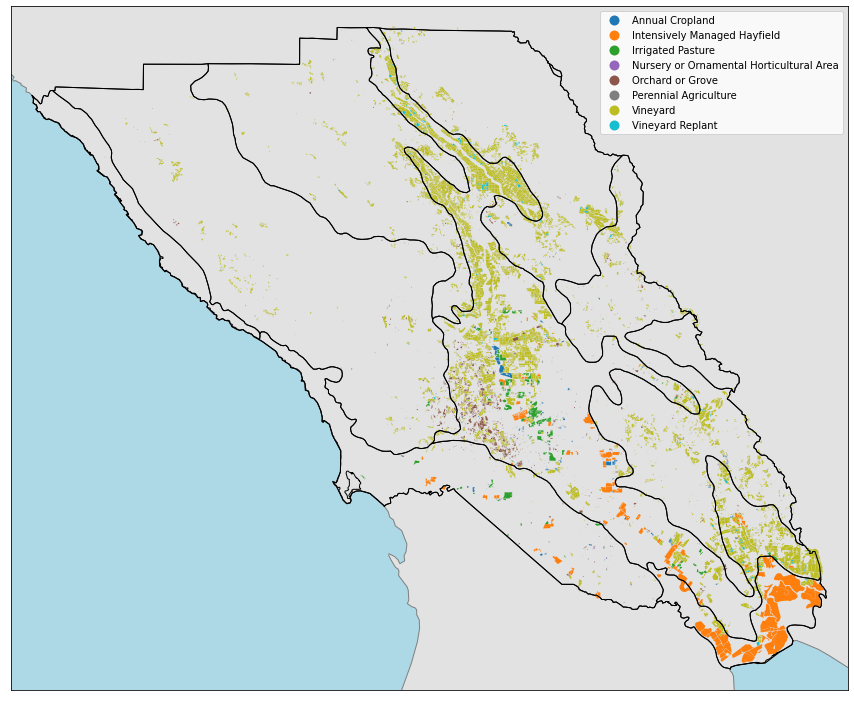

In [23]:
fig, ax = plt.subplots(figsize=(15,15))
ca_state.plot(ax=ax, edgecolor = "grey", color = "#e2e2e2")
soco_bound.plot(ax=ax, edgecolor = "black", color = "None")
sonoma_veg_ag.plot(ax=ax, column = "LIFEFORM", legend = True)
ecoregions_simp.plot(ax=ax, color = "None", legend = True)
ax.set_xlim(xlim_soco)
ax.set_ylim(ylim_soco)
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('#add8e6')
ax

(<Figure size 1080x1080 with 1 Axes>, <AxesSubplot:>)

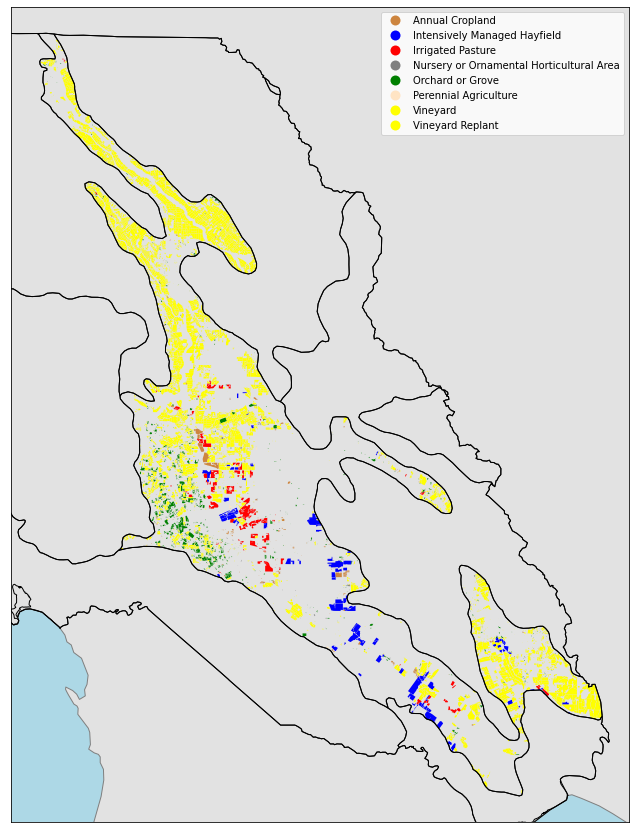

In [16]:
map_ecoregion_char(ecoregions_simp, sonoma_veg_ag, "Napa-Sonoma-Russian River Valleys", veg_cmap, "LIFEFORM")

#### Landuse

In [5]:
# landuse colors
landuse_colors = {
"Diverse Agriculture": "#7b5836",
"General Commercial": "#ff6600",
"General Industrial": "#fbc312",
"Limited Commercial": "#ffaf7a",
"Land Extensive Agriculture": "#D2B48C",
"Limited Industrial": "#fcfc64",
"Land Intensive Agriculture": "#422a14",
"Public / Quasi-public": "#006a4e",
"Rural Residential": "#80a3d8",
"Resources and Rural Development": "#6Eb440",
"Recreation and Visitor Serving Commercial": "#E79796",
"Urban Residential": "#1167b1"
}

In [18]:
from matplotlib.colors import ListedColormap
land_cmap = ListedColormap([landuse_colors[x] for x in sorted(landuse_simp.landuse.unique())])

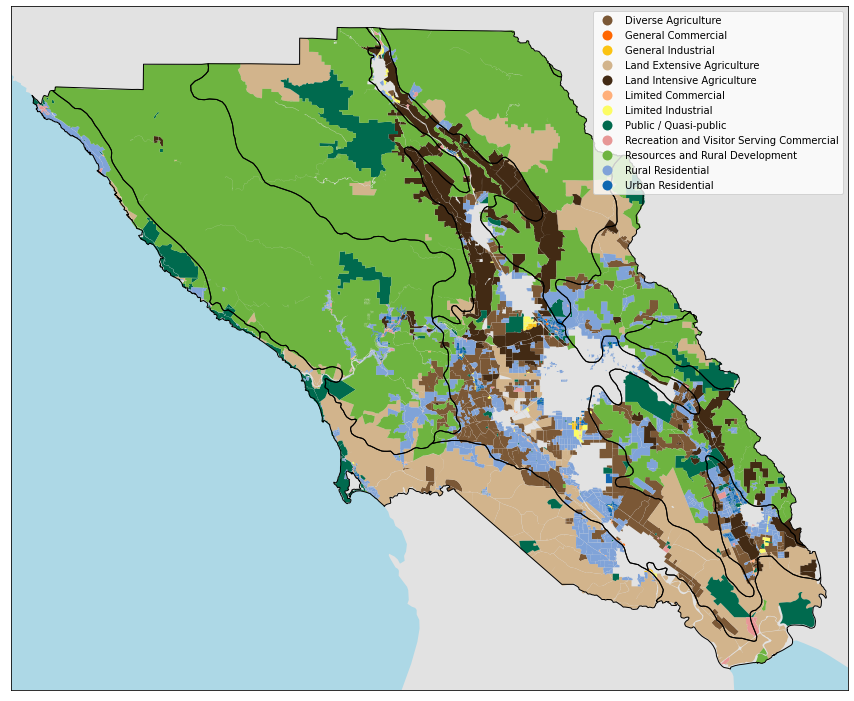

In [19]:
fig, ax = plt.subplots(figsize=(15,15))
ca_state.plot(ax=ax, color = "#e2e2e2")
landuse_simp.plot(ax=ax, column = "landuse", cmap=land_cmap, legend = True)
ecoregions_simp.plot(ax=ax, color = "None",  edgecolor = "black")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(xlim_soco)
ax.set_ylim(ylim_soco)
ax.set_facecolor('#add8e6')


In [ ]:
from tqdm import tqdm
# loop through the ecoregions to create the landuse maps
for eco in tqdm(ecoregion_list):
    fig, _ = map_ecoregion_char(ecoregions_simp, landuse_simp, eco, landuse_colors, "landuse")
    snake_case_eco = eco.lower().replace(" ", "_").replace("/", "_").replace("-", "_")
    fig.savefig(f"../output/maps/{snake_case_eco}_landuse.png", dpi=350)

#### Protected Lands

[]

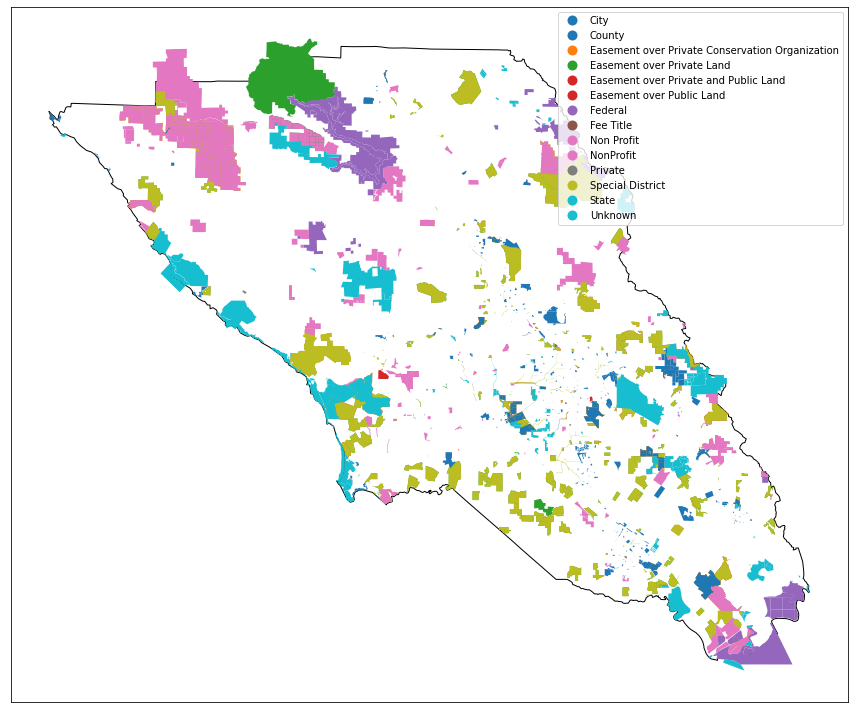

In [71]:
fig, ax = plt.subplots(figsize=(15,15))
soco_bound.plot(ax=ax, edgecolor = "black", color = "None")
protected_lands.plot(ax=ax, column = "holding_ow", legend = True)
#ecoregions_simp.plot(ax=ax, edgecolor = "black", color = "None")
ax.set_xticks([])
ax.set_yticks([])

In [72]:
protected_dissolved = protected_lands.dissolve()

In [75]:
soco_bound['geometry'].area / 43560

0    1.018738e+06
dtype: float64

#### Zoning

In [8]:
zoning.head()

,OBJECTID,BASEZONING,DISTRICT,DENSITY,Shape_Leng,Shape_Area,geometry
0,1,AR B6 1,AR,1,3091.035360,502442.105373,"POLYGON ((6301041.075 2022284.567, 6300939.942..."
1,2,AR B6 1,AR,1,2178.654764,272942.428678,"POLYGON ((6405914.392 1910558.517, 6405687.033..."
2,3,AR B6 1,AR,1,1879.295046,199733.330755,"POLYGON ((6409239.142 1897032.667, 6409174.200..."
3,4,AR B6 1,AR,1,1634.635993,143196.579648,"POLYGON ((6303515.167 2021768.608, 6303663.567..."
4,5,AR B6 1,AR,1,1770.774187,114928.345325,"POLYGON ((6304774.175 2021397.842, 6304765.817..."


<AxesSubplot:>

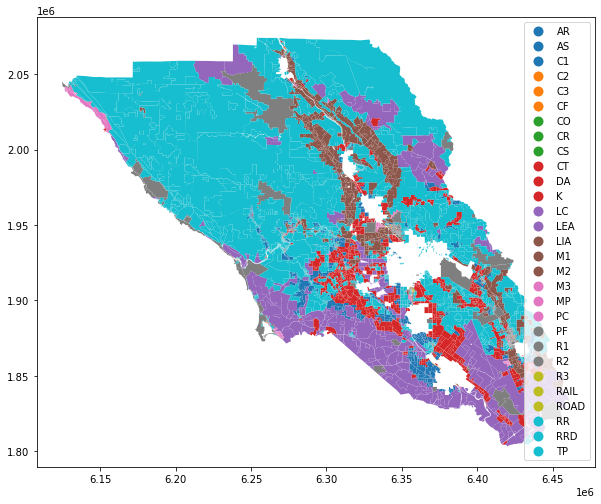

In [10]:
zoning.plot(column = "DISTRICT", figsize=(10,10), legend = True)

### Demographics

In [16]:
demographics["area_acres"] = demographics['geometry'].area / 43560
demographics_pop = demographics[demographics["vrbl_nm"] == "total_pop"]
housing_units = demographics[demographics["vrbl_nm"] == "housing_units"]

In [17]:
# calculate densities
demographics_pop["population_density"] = demographics_pop["estimat"]/demographics_pop["area_acres"]
housing_units["housing_density"] = housing_units["estimat"]/housing_units["area_acres"]

C:\Users\AMarley\Anaconda3\envs\spatialds\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


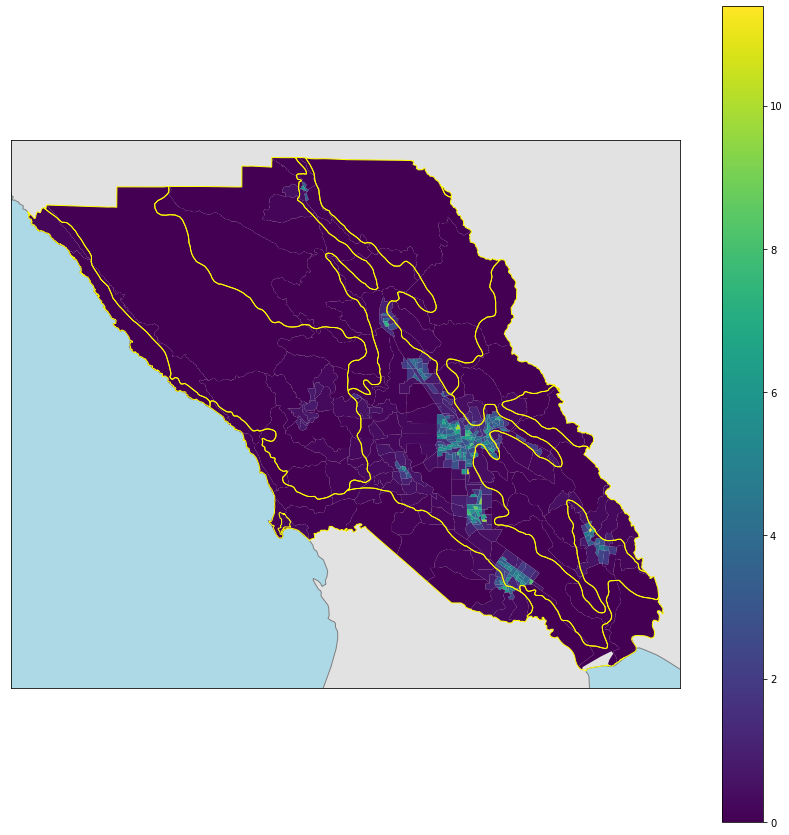

In [18]:
fig, ax = plt.subplots(figsize=(15,15))
ca_state.plot(ax=ax, edgecolor = "grey", color = "#e2e2e2")
housing_units.plot(ax=ax, column = "housing_density", legend = True)
ecoregions_simp.plot(ax=ax, color = "None",  edgecolor = "yellow")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(xlim_soco)
ax.set_ylim(ylim_soco)
ax.set_facecolor('#add8e6')

## PIE CHARTS

In [16]:
# Create pie plot
from matplotlib.colors import ListedColormap
def make_zone_piechart(ecoregion_char, which_eoi:str, value:str, label:str, colors):
       # filter to an ecoregion
       ecoregion_char = ecoregion_char[ecoregion_char["ecoregion"]==which_eoi]

       # set the simplified veg map colors
       if isinstance(colors, dict):
              cmap = ListedColormap([colors[x] for x in ecoregion_char["Haz_Catego"].unique()])
       else:
              cmap=ListedColormap(colors)
              
       pie_colors = cmap(np.linspace(0., 1., len(ecoregion_char[value])))

       # Make pie chart
       fig, ax = plt.subplots(figsize=(10,10))
       ax.pie(ecoregion_char[value], colors = pie_colors,
              wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'}, textprops={'size': 'x-large'}) #autopct='%1.1f%%', labels=ecoregion_char['lifeform+perc']
       ax.axis('equal') 
       ax.legend(labels = ecoregion_char[label], bbox_to_anchor=(0,1),frameon=False, labelcolor = "black", prop = {'weight':'bold', 'size': 20})
       return fig, ax

#### Sonoma Veg

In [ ]:
# colors
veg_cols = ["peru", "blue", "red", "grey", "green", "bisque", "yellow"]

vegetation for whole county

In [29]:
sonoma_veg_simp_county = sonoma_veg_simp.dissolve(by = "natural_si").rest_index()
sonoma_veg_simp_county["acres"] = sonoma_veg_simp_county['geometry'].area / 43560

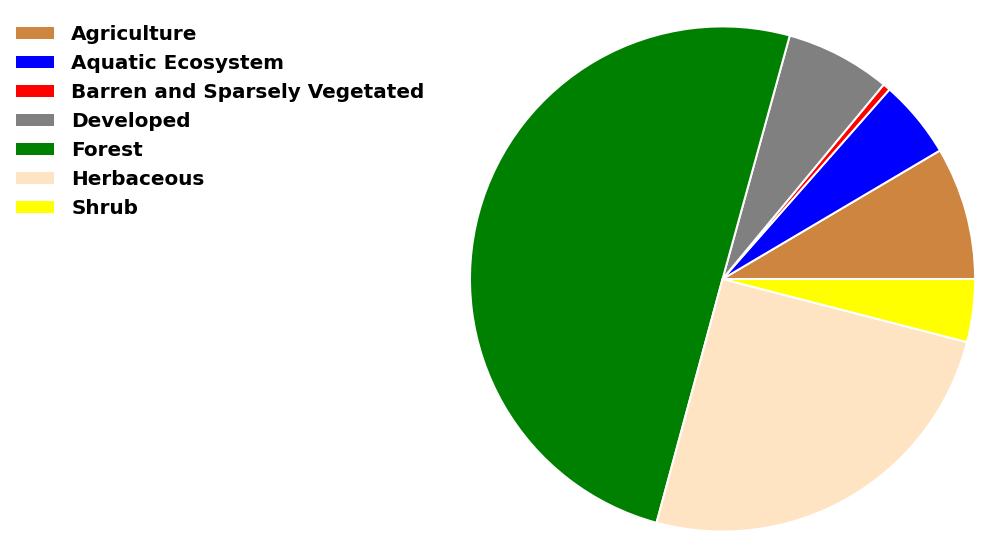

In [38]:
cmap = ListedColormap(veg_cols)
pie_colors = cmap(np.linspace(0., 1., len(sonoma_veg_simp_county["acres"])))

# Make pie chart
fig, ax = plt.subplots(figsize=(10,10))
ax.pie(sonoma_veg_simp_county["acres"], colors = pie_colors,
        wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'}, textprops={'size': 'x-large'}) 
ax.axis('equal') 
ax.legend(labels = sonoma_veg_simp_county["natural_si"], bbox_to_anchor=(0,1),frameon=False, labelcolor = "black", prop = {'weight':'bold', 'size': 20})

vegetation for each ecoregion

In [52]:
# variables for iterating over
ecoregion_list = sonoma_veg_percs.ecoregion.unique()

In [ ]:
# for loop to make and save a pie chart for every ecoregion
for eco in tqdm(ecoregion_list):
    fig, _ = make_zone_piechart(sonoma_veg_percs, eco, "percent_of_ecoregion", "lifeform+perc", veg_cols)
    snake_case_eco = eco.lower().replace(" ", "_").replace("/", "_").replace("-", "_")
    fig.savefig(f"../output/graphs/{snake_case_eco}_veg_pie_blck.png", dpi=350)

#### Landuse

landuse in the entire county

In [11]:
landuse_simp["acres"] = landuse_simp['geometry'].area / 43560

In [23]:
sum(landuse_simp["acres"])

946459.182610889

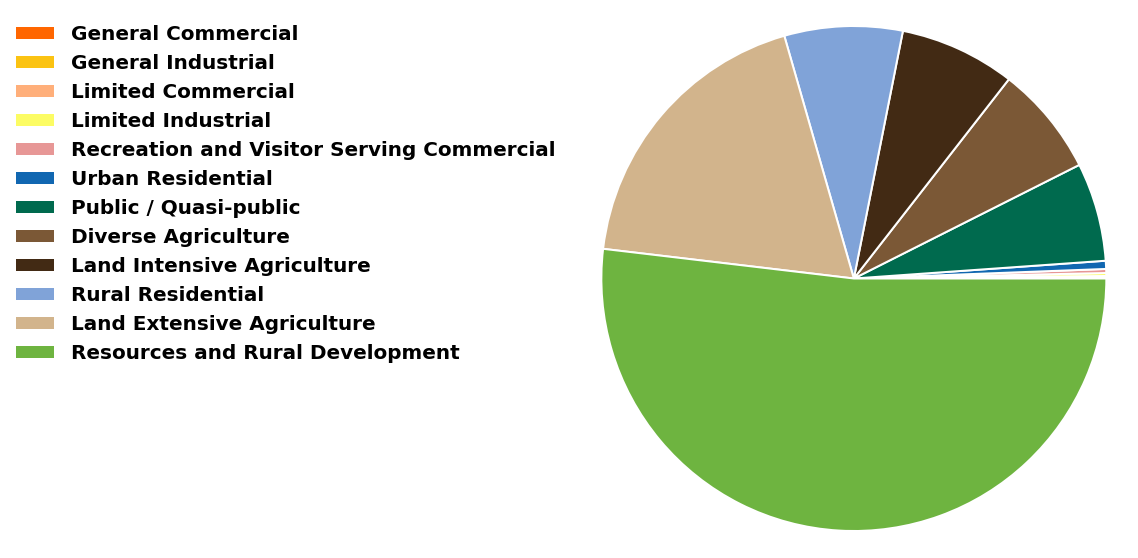

In [22]:
# colors for the pie chart
landuse_simp = landuse_simp.sort_values(by = "acres")
cmap = ListedColormap([landuse_colors[x] for x in landuse_simp["landuse"].unique()])
pie_colors = cmap(np.linspace(0., 1., len(landuse_simp["acres"])))

# Make pie chart
fig, ax = plt.subplots(figsize=(10,10))
ax.pie(landuse_simp["acres"], colors = pie_colors,
        wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'}, textprops={'size': 'x-large'}) 
ax.axis('equal') 
ax.legend(labels = landuse_simp["landuse"], bbox_to_anchor=(0,1),frameon=False, labelcolor = "black", prop = {'weight':'bold', 'size': 20})

Landuse by ecoregion

In [ ]:
# add landuse percentage columns and remove categories with less than 0.0 cover
landuse_percs["perc_round"] = landuse_percs['percent_of_ecoregion'].round(1)
landuse_percs = landuse_percs[landuse_percs["perc_round"] > 0.0]
landuse_percs["landuse+perc"] = landuse_percs['landuse'] + " (" + landuse["perc_round"].astype(str) + "%)"

In [ ]:
# pie chart of landuse in all of the county
make_zone_piechart(landuse_percs, eco, "acres", "landuse+perc", landuse_colors)

In [ ]:
# for loop to make and save a pie chart for every ecoregion
for eco in tqdm(ecoregion_list):
    fig, _ = make_zone_piechart(landuse_percs, eco, "acres", "landuse+perc", landuse_colors)
    snake_case_eco = eco.lower().replace(" ", "_").replace("/", "_").replace("-", "_")
    fig.savefig(f"../output/graphs/{snake_case_eco}_landuse_pie_blck.png", dpi=350)

#### Critical Facilities

In [31]:
#crit_facili["haz_category+number_facil"] = crit_facili["Haz_Catego"] + " (" + crit_facili["counts"].astype(str) + ")"
crit_facili = crit_facili.rename(columns = {"l4_simple": "ecoregion"})
crit_facili.head()

,Unnamed: 0,ecoregion,Haz_Catego,counts,haz_category+number_facil
0,0,Bay Flats,Communication,1,Communication (1)
1,1,Bay Flats,Energy,1,Energy (1)
2,2,Bay Flats,"Food, Water, Shelter",3,"Food, Water, Shelter (3)"
3,3,Bay Flats,Hazardous Material,99,Hazardous Material (99)
4,4,Bay Flats,Safety and Security,3,Safety and Security (3)


In [30]:
facility_colors = {
    'Communication': "#046C9A",
    'Energy': "#F98400",
    'Food, Water, Shelter': "#00A08A",
    'Hazardous Material': "#FF0000", 
    'Safety and Security': "#D69C4E", 
    'Transportation': "#ECCBAE",
    'Health and Medical':  "#ABDDDE"
}

In [ ]:
make_zone_piechart(crit_facili, "Bodega Coastal Hills", "counts", "haz_category+number_facil", facility_colors)

In [ ]:
ecoregion_list = crit_facili.ecoregion.unique()
for eco in tqdm(ecoregion_list):
    fig, _ = make_zone_piechart(crit_facili, eco, "counts", "Haz_Catego", facility_colors)
    snake_case_eco = eco.lower().replace(" ", "_").replace("/", "_").replace("-", "_")
    fig.savefig(f"../output/graphs/{snake_case_eco}_critical_facility_pie.png", dpi=350)

In [4]:
crit_facili.head()

,Unnamed: 0,l4_simple,Haz_Catego,counts
0,0,Bay Flats,Communication,1
1,1,Bay Flats,Energy,1
2,2,Bay Flats,"Food, Water, Shelter",3
3,3,Bay Flats,Hazardous Material,99
4,4,Bay Flats,Safety and Security,3


scratch:

In [ ]:
## Scratch ###
veg_top_5 = zones_veg_nat_top[["ecoregion", "natural_lifeform"]]
veg_top_5[["top"]] = "top_5"
veg_top_5.head()

# identify what vegetation types are the 5 most common
tester = zones_veg_nat.merge(veg_top_5, how='left', on = ['ecoregion', "natural_lifeform"])
tester["natural_lifeform_fix"] = np.select([tester['top']=='top_5'], [tester['natural_lifeform']], ['other'])
tester.head()